<a href="https://colab.research.google.com/github/Hitakshichugh/AI-Capsule-Wardrobe-Generator/blob/main/outfitgenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install torch torchvision transformers pillow opencv-python scikit-learn matplotlib pandas


In [ ]:
from pathlib import Path

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from transformers import CLIPModel, CLIPProcessor

import cv2
from sklearn.cluster import KMeans

In [ ]:
from pathlib import Path
import pandas as pd

# where your uploaded images are stored on disk
# (match this to your app; for a simple notebook test,
# you can just use a folder called "uploads" next to the notebook)
upload_dir = Path("uploads")  # or Path("static/uploads") for Flask
upload_dir.mkdir(exist_ok=True, parents=True)

# global storage for wardrobe
wardrobe_records = []
embeddings_dict = {}
wardrobe_df = pd.DataFrame()

In [ ]:
def add_wardrobe_item(image_path: str | Path):
    """
    process ONE new clothing image and add it to the wardrobe.

    image_path: path to the saved image file
                (e.g. 'uploads/white_top.jpg' or 'static/uploads/blue_jeans.png')

    returns: the record dict that was added.
    """
    global wardrobe_records, embeddings_dict, wardrobe_df

    path = Path(image_path)
    filename = path.name

    # 1) open image
    pil_img = load_image(path)

    # 2) classify category using CLIP (option 3)
    cat, prompt, conf, _ = classify_image_category(path)

    # 3) CLIP embedding
    emb = get_image_embedding(model, processor, device, pil_img)
    embeddings_dict[filename] = emb

    # 4) color features
    cv2_img = pil_to_cv2(pil_img)
    dom_bgr = get_dominant_color_bgr(cv2_img, k=4, crop_size=0.6)
    dom_hsv = bgr_to_hsv(dom_bgr)
    color_group = categorize_color(dom_hsv)

    # 5) build and store record
    record = {
        "filename": filename,
        "full_path": str(path),
        "category": cat,
        "clip_prompt": prompt,
        "clip_conf": conf,
        "dominant_b": dom_bgr[0],
        "dominant_g": dom_bgr[1],
        "dominant_r": dom_bgr[2],
        "hue": dom_hsv[0],
        "sat": dom_hsv[1],
        "val": dom_hsv[2],
        "color_group": color_group,
    }

    wardrobe_records.append(record)
    wardrobe_df = pd.DataFrame(wardrobe_records)

    print(f"added: {filename:40s} -> {cat:7s} (conf={conf:.3f}) [{color_group}]")
    return record

In [ ]:
# if you manually drop some test images into the "uploads" folder,
# you can test like this:

test_files = list(upload_dir.glob("*"))
print("found", len(test_files), "files in uploads")

for p in test_files:
    add_wardrobe_item(p)

wardrobe_df

found 3 files in uploads
added: 01_6_flat.jpg                            -> top     (conf=0.060) [warm]
added: 02_2_side.jpg                            -> bottom  (conf=0.058) [warm]
added: 02_1_front.jpg                           -> top     (conf=0.058) [warm]


,filename,full_path,category,clip_prompt,clip_conf,dominant_b,dominant_g,dominant_r,hue,sat,val,color_group
0,01_6_flat.jpg,uploads/01_6_flat.jpg,top,a photo of a tank top (top),0.060063,88,93,219,1,153,219,warm
1,02_2_side.jpg,uploads/02_2_side.jpg,bottom,a photo of jeans (bottom),0.057931,109,120,220,3,129,220,warm
2,02_1_front.jpg,uploads/02_1_front.jpg,top,a photo of a blouse (top),0.057628,31,39,54,10,109,54,warm


In [ ]:
def load_clip_model(device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print("using device:", device)

    model_name = "openai/clip-vit-base-patch32"
    model = CLIPModel.from_pretrained(model_name).to(device)
    processor = CLIPProcessor.from_pretrained(model_name)
    return model, processor, device

model, processor, device = load_clip_model()

using device: cpu


In [ ]:
def load_image(path: Path) -> Image.Image:
    return Image.open(path).convert("RGB")


def get_image_embedding(model, processor, device, image: Image.Image) -> torch.Tensor:
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        feats = model.get_image_features(**inputs)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats.squeeze(0).cpu()  # 1d tensor


In [ ]:
if image_files:
    test_emb = get_image_embedding(model, processor, device, load_image(image_files[0]))
    print("embedding shape:", test_emb.shape)
else:
    print("no images found; check zip/extract.")


embedding shape: torch.Size([512])


In [ ]:
category_prompts = [
    "a photo of a t-shirt (top)",
    "a photo of a shirt (top)",
    "a photo of a blouse (top)",
    "a photo of a hoodie (top)",
    "a photo of a sweater (top)",
    "a photo of a crop top (top)",
    "a photo of a tank top (top)",

    "a photo of jeans (bottom)",
    "a photo of pants (bottom)",
    "a photo of trousers (bottom)",
    "a photo of shorts (bottom)",
    "a photo of a skirt (bottom)",
    "a photo of a long skirt (bottom)",

    "a photo of a jacket (jacket)",
    "a photo of a coat (jacket)",
    "a photo of a blazer (jacket)",
    "a photo of an overcoat (jacket)",
    "a photo of a denim jacket (jacket)",
]

prompt_to_category = {}
for idx, text in enumerate(category_prompts):
    if "(top)" in text:
        prompt_to_category[idx] = "top"
    elif "(bottom)" in text:
        prompt_to_category[idx] = "bottom"
    elif "(jacket)" in text:
        prompt_to_category[idx] = "jacket"
    else:
        prompt_to_category[idx] = "unknown"

prompt_to_category


{0: 'top',
 1: 'top',
 2: 'top',
 3: 'top',
 4: 'top',
 5: 'top',
 6: 'top',
 7: 'bottom',
 8: 'bottom',
 9: 'bottom',
 10: 'bottom',
 11: 'bottom',
 12: 'bottom',
 13: 'jacket',
 14: 'jacket',
 15: 'jacket',
 16: 'jacket',
 17: 'jacket'}

In [ ]:
def get_text_embeddings(model, processor, device, prompts):
    inputs = processor(
        text=prompts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    with torch.no_grad():
        feats = model.get_text_features(**inputs)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats.cpu()

text_embs = get_text_embeddings(model, processor, device, category_prompts)
print("text embeddings shape:", text_embs.shape)


text embeddings shape: torch.Size([18, 512])


In [ ]:
def classify_image_category(path: Path):
    pil_img = load_image(path)
    img_emb = get_image_embedding(model, processor, device, pil_img)

    sims = img_emb.unsqueeze(0) @ text_embs.T        # (1, num_prompts)
    probs = F.softmax(sims, dim=-1).squeeze(0)      # (num_prompts,)

    best_idx = int(torch.argmax(probs).item())
    best_prompt = category_prompts[best_idx]
    best_cat = prompt_to_category.get(best_idx, "unknown")
    best_conf = float(probs[best_idx].item())

    return best_cat, best_prompt, best_conf, pil_img

In [ ]:
cv2_img = pil_to_cv2(pil_img)

dom_bgr = get_dominant_color_bgr(cv2_img, k=4, crop_size=0.6)
dom_hsv = bgr_to_hsv(dom_bgr)
color_group = categorize_color(dom_hsv)

wardrobe_records.append({
    "rel_path": filename,
    "full_path": str(path),
    "category": cat,
    "clip_prompt": prompt,
    "clip_conf": conf,
    "dominant_b": dom_bgr[0],
    "dominant_g": dom_bgr[1],
    "dominant_r": dom_bgr[2],
    "hue": dom_hsv[0],
    "sat": dom_hsv[1],
    "val": dom_hsv[2],
    "color_group": color_group,
})

file: 04_3_back.jpg
bgr: (110, 111, 141) hsv: (1, 56, 141) group: warm


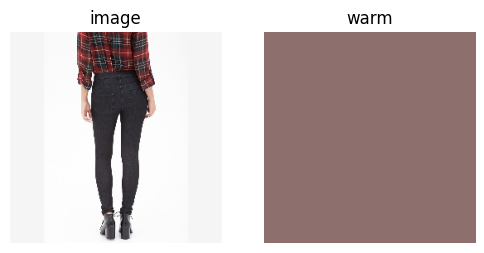

In [ ]:
if image_files:
    p = image_files[500]
    img = load_image(p)
    cv2_img = pil_to_cv2(img)
    dom_bgr = get_dominant_color_bgr(cv2_img)
    dom_hsv = bgr_to_hsv(dom_bgr)
    group = categorize_color(dom_hsv)

    print("file:", p.name)
    print("bgr:", dom_bgr, "hsv:", dom_hsv, "group:", group)

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(img); ax[0].axis("off"); ax[0].set_title("image")
    patch = np.zeros((100, 100, 3), dtype=np.uint8)
    b, g, r = dom_bgr
    patch[:, :] = [r, g, b]
    ax[1].imshow(patch); ax[1].axis("off"); ax[1].set_title(group)
    plt.show()
else:
    print("no images to test.")

In [ ]:
tops = wardrobe_df[wardrobe_df["category"] == "top"]["filename"].tolist()
bottoms = wardrobe_df[wardrobe_df["category"] == "bottom"]["filename"].tolist()
jackets = wardrobe_df[wardrobe_df["category"] == "jacket"]["filename"].tolist()

print("tops   :", len(tops))
print("bottoms:", len(bottoms))
print("jackets:", len(jackets))

tops   : 2
bottoms: 1
jackets: 0


In [ ]:
def cosine_sim(t1: torch.Tensor, t2: torch.Tensor) -> float:
    # cosine similarity formula
    return float(torch.dot(t1, t2) / (torch.norm(t1) * torch.norm(t2)))

def outfit_style_score(filenames: list[str]) -> float:
    sims = []
    for i in range(len(filenames)):
        for j in range(i + 1, len(filenames)):
            sims.append(
                cosine_sim(
                    embeddings_dict[filenames[i]],
                    embeddings_dict[filenames[j]]
                )
            )
    if not sims:
        return 0.0
    return float(np.mean(sims))

In [ ]:
import random

w_color = 0.6
w_style = 0.4
max_combos = 8000   # avoid explosion

all_combos = []

for t in tops:
    for b in bottoms:
        all_combos.append((t, b, None))
        for j in jackets:
            all_combos.append((t, b, j))

print("total possible combos (before sampling):", len(all_combos))

if len(all_combos) > max_combos:
    print(f"too many combos, sampling {max_combos} for scoring.")
    all_combos = random.sample(all_combos, max_combos)

def outfit_color_score(color_groups: list[str]) -> float:
    """
    color_groups: list of color group strings (e.g., ['warm', 'cool', 'neutral'])
    returns: score from 0 to 10 for color compatibility
    """
    # simple rules for now
    num_warm = color_groups.count('warm')
    num_cool = color_groups.count('cool')
    num_neutral = color_groups.count('neutral')

    # penalty for mixing warm and cool (unless neutral is dominant)
    if num_warm > 0 and num_cool > 0 and num_neutral < 1:
        return 3.0
    # bonus for sticking to one temperature
    if num_warm > 0 and num_cool == 0 or num_cool > 0 and num_warm == 0:
        return 9.0
    # neutral outfits are fine
    if num_neutral == len(color_groups):
        return 8.0

    # default score
    return 6.0

outfit_rows = []

for t, b, j in all_combos:
    names = [t, b] if j is None else [t, b, j]

    groups = []
    for name in names:
        cg = wardrobe_df.loc[wardrobe_df["filename"] == name, "color_group"].iloc[0]
        groups.append(cg)

    c_score = outfit_color_score(groups)
    s_score = outfit_style_score(names)
    total = w_color * c_score + w_style * s_score

    outfit_rows.append({
        "top": t,
        "bottom": b,
        "jacket": j,
        "color_score": c_score,
        "style_score": s_score,
        "total_score": total,
    })

outfits_df = pd.DataFrame(outfit_rows)

total possible combos (before sampling): 2


In [ ]:
def show_outfit(row):
    items = []
    labels = []

    def get_path(name: str) -> Path:
        fp = wardrobe_df.loc[wardrobe_df["filename"] == name, "full_path"].iloc[0]
        return Path(fp)

    # top
    top_path = get_path(row["top"])
    top_img = Image.open(top_path).convert("RGB")
    items.append(top_img)
    labels.append("Top")

    # bottom
    bottom_path = get_path(row["bottom"])
    bottom_img = Image.open(bottom_path).convert("RGB")
    items.append(bottom_img)
    labels.append("Bottom")

    # jacket
    if row["jacket"] is not None:
        jacket_path = get_path(row["jacket"])
        jacket_img = Image.open(jacket_path).convert("RGB")
        items.append(jacket_img)
        labels.append("Jacket")

    cols = len(items)
    fig, axes = plt.subplots(1, cols, figsize=(5 * cols, 5))
    if cols == 1:
        axes = [axes]

    for ax, img, label in zip(axes, items, labels):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


Day 1 — Outfit Score: 5.718


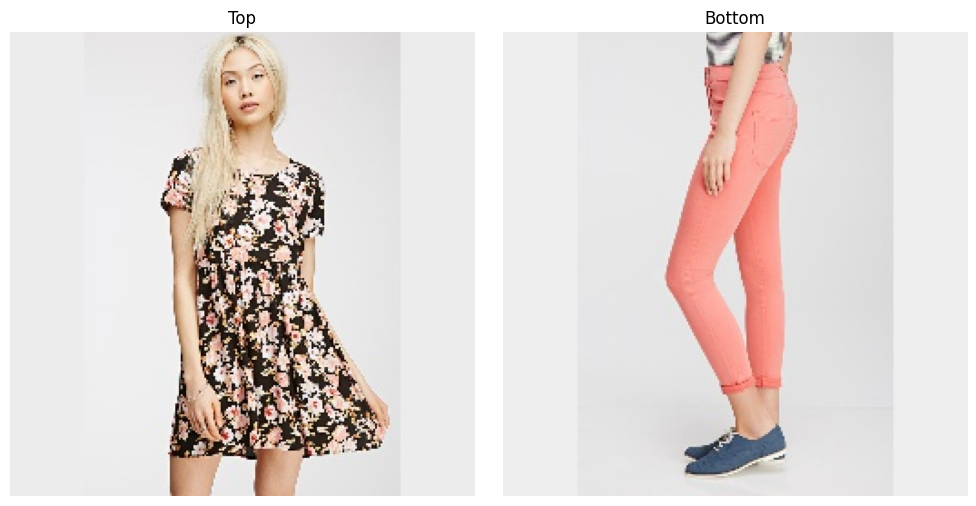

Day 2 — Outfit Score: 5.617


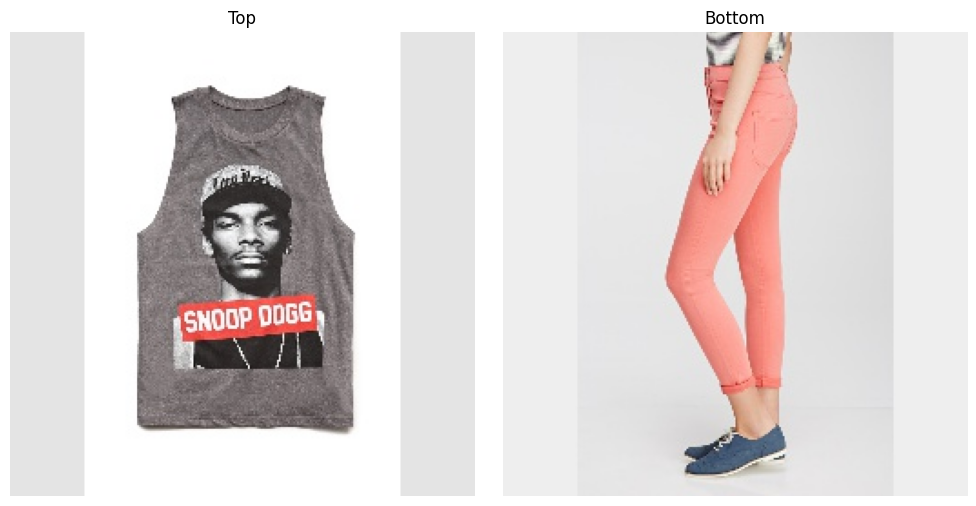

In [ ]:
k = 30
top_k = min(k, len(outfits_df))
best_outfits = outfits_df.sort_values("total_score", ascending=False).head(top_k).reset_index(drop=True)
best_outfits.insert(0, "day", range(1, len(best_outfits) + 1))

for i, row in best_outfits.iterrows():
    print(f"Day {row['day']} — Outfit Score: {row['total_score']:.3f}")
    show_outfit(row)

In [ ]:
from pathlib import Path
import pandas as pd

# this must point to the folder that actually contains your images
# if your folder is called something else, change "uploads" to that name
upload_dir = Path("uploads")
print("upload_dir:", upload_dir.resolve())

# reset wardrobe storage
wardrobe_records = []
embeddings_dict = {}
wardrobe_df = pd.DataFrame()

upload_dir: /content/uploads


In [ ]:
import cv2
import numpy as np
from PIL import Image

def add_wardrobe_item(path):
    """
    take ONE image file path, classify it, get embedding + color,
    and append it to wardrobe_df.
    """
    global wardrobe_records, embeddings_dict, wardrobe_df

    path = Path(path)
    pil_img = Image.open(path).convert("RGB")

    # 1) classify category with CLIP
    category = classify_image_category(path)   # must already be defined

    # 2) embedding
    emb = get_image_embedding(pil_img)        # must already be defined
    embeddings_dict[path.name] = emb

    # 3) simple color group (you can swap with k-means version later)
    bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    h = int(hsv[0, 0, 0])

    if h < 40:
        color_group = "warm"
    elif h < 90:
        color_group = "cool"
    else:
        color_group = "neutral"

    record = {
        "filename": path.name,
        "full_path": str(path),
        "category": category,          # 👈 this is the column you were missing
        "color_group": color_group,
    }

    wardrobe_records.append(record)
    wardrobe_df = pd.DataFrame(wardrobe_records)

    print(f"added → {path.name:25s} | category={category:7s} | color={color_group}")
    return record

In [ ]:
# list all image files in uploads/
image_files = [p for p in upload_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".webp"]]

print("found", len(image_files), "files in uploads")
for p in image_files:
    add_wardrobe_item(p)

print("\nwardrobe_df columns:", wardrobe_df.columns.tolist())
wardrobe_df.head()

found 7 files in uploads
added → 01_1_front.jpg            | category=top     | color=warm
added → 01_6_flat.jpg             | category=top     | color=warm
added → 04_2_side.jpg             | category=bottom  | color=warm
added → 02_2_side.jpg             | category=bottom  | color=warm
added → 02_1_front.jpg            | category=dress   | color=warm
added → shorts.jpg                | category=romper  | color=warm
added → 02_7_additional.jpg       | category=top     | color=warm

wardrobe_df columns: ['filename', 'full_path', 'category', 'color_group']


,filename,full_path,category,color_group
0,01_1_front.jpg,uploads/01_1_front.jpg,top,warm
1,01_6_flat.jpg,uploads/01_6_flat.jpg,top,warm
2,04_2_side.jpg,uploads/04_2_side.jpg,bottom,warm
3,02_2_side.jpg,uploads/02_2_side.jpg,bottom,warm
4,02_1_front.jpg,uploads/02_1_front.jpg,dress,warm


In [ ]:
tops    = wardrobe_df[wardrobe_df["category"] == "top"]["filename"].tolist()
bottoms = wardrobe_df[wardrobe_df["category"] == "bottom"]["filename"].tolist()
skirts  = wardrobe_df[wardrobe_df["category"] == "skirt"]["filename"].tolist()
dresses = wardrobe_df[wardrobe_df["category"] == "dress"]["filename"].tolist()
rompers = wardrobe_df[wardrobe_df["category"] == "romper"]["filename"].tolist()
jackets = wardrobe_df[wardrobe_df["category"] == "jacket"]["filename"].tolist()

print("tops   :", tops)
print("bottoms:", bottoms)
print("skirts :", skirts)
print("dresses:", dresses)
print("rompers:", rompers)
print("jackets:", jackets)

tops   : ['01_1_front.jpg', '01_6_flat.jpg', '02_7_additional.jpg']
bottoms: ['04_2_side.jpg', '02_2_side.jpg']
skirts : []
dresses: ['02_1_front.jpg']
rompers: ['shorts.jpg']
jackets: []


In [ ]:
# color compatibility
def pair_color_score(g1: str, g2: str) -> float:
    # neutral goes with anything
    if g1 == "neutral" or g2 == "neutral":
        return 3.0
    # same family (warm–warm or cool–cool)
    if g1 == g2:
        return 2.5
    # clashy but maybe fun
    return 1.0

def outfit_color_score(groups: list[str]) -> float:
    score = 0.0
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            score += pair_color_score(groups[i], groups[j])
    return score

# style similarity using clip embeddings
def cosine_sim(a: torch.Tensor, b: torch.Tensor) -> float:
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

def outfit_style_score(filenames: list[str]) -> float:
    sims = []
    for i in range(len(filenames)):
        for j in range(i + 1, len(filenames)):
            sims.append(
                cosine_sim(
                    embeddings_dict[filenames[i]],
                    embeddings_dict[filenames[j]]
                )
            )
    if not sims:
        return 0.0
    return float(np.mean(sims))

In [ ]:
# group by category
tops    = wardrobe_df[wardrobe_df["category"] == "top"]["filename"].tolist()
bottoms = wardrobe_df[wardrobe_df["category"] == "bottom"]["filename"].tolist()
skirts  = wardrobe_df[wardrobe_df["category"] == "skirt"]["filename"].tolist()
dresses = wardrobe_df[wardrobe_df["category"] == "dress"]["filename"].tolist()
rompers = wardrobe_df[wardrobe_df["category"] == "romper"]["filename"].tolist()
jackets = wardrobe_df[wardrobe_df["category"] == "jacket"]["filename"].tolist()

print("tops   :", tops)
print("bottoms:", bottoms)
print("skirts :", skirts)
print("dresses:", dresses)
print("rompers:", rompers)
print("jackets:", jackets)

w_color = 0.6   # weight for color harmony
w_style = 0.4   # weight for style similarity
max_combos = 8000  # safety cap if wardrobe is huge

all_outfits = []

# 1) top + bottom
for t in tops:
    for b in bottoms:
        all_outfits.append((t, b, None))
        for j in jackets:
            all_outfits.append((t, b, j))

# 2) top + skirt
for t in tops:
    for s in skirts:
        all_outfits.append((t, s, None))
        for j in jackets:
            all_outfits.append((t, s, j))

# 3) dresses (one-piece) – alone or with jacket
for d in dresses:
    all_outfits.append((d, None, None))
    for j in jackets:
        all_outfits.append((d, None, j))

# 4) rompers (one-piece) – alone or with jacket
for r in rompers:
    all_outfits.append((r, None, None))
    for j in jackets:
        all_outfits.append((r, None, j))

print("total raw outfits:", len(all_outfits))

# optional: reduce if too many
import random
if len(all_outfits) > max_combos:
    all_outfits = random.sample(all_outfits, max_combos)
    print("sampled down to:", len(all_outfits))

tops   : ['01_1_front.jpg', '01_6_flat.jpg', '02_7_additional.jpg']
bottoms: ['04_2_side.jpg', '02_2_side.jpg']
skirts : []
dresses: ['02_1_front.jpg']
rompers: ['shorts.jpg']
jackets: []
total raw outfits: 8


In [ ]:
# group by category
tops    = wardrobe_df[wardrobe_df["category"] == "top"]["filename"].tolist()
bottoms = wardrobe_df[wardrobe_df["category"] == "bottom"]["filename"].tolist()
skirts  = wardrobe_df[wardrobe_df["category"] == "skirt"]["filename"].tolist()
dresses = wardrobe_df[wardrobe_df["category"] == "dress"]["filename"].tolist()
rompers = wardrobe_df[wardrobe_df["category"] == "romper"]["filename"].tolist()
jackets = wardrobe_df[wardrobe_df["category"] == "jacket"]["filename"].tolist()

print("tops   :", tops)
print("bottoms:", bottoms)
print("skirts :", skirts)
print("dresses:", dresses)
print("rompers:", rompers)
print("jackets:", jackets)

w_color = 0.6   # weight for color harmony
w_style = 0.4   # weight for style similarity
max_combos = 8000  # safety cap if wardrobe is huge

all_outfits = []

# 1) top + bottom
for t in tops:
    for b in bottoms:
        all_outfits.append((t, b, None))
        for j in jackets:
            all_outfits.append((t, b, j))

# 2) top + skirt
for t in tops:
    for s in skirts:
        all_outfits.append((t, s, None))
        for j in jackets:
            all_outfits.append((t, s, j))

# 3) dresses (one-piece) – alone or with jacket
for d in dresses:
    all_outfits.append((d, None, None))
    for j in jackets:
        all_outfits.append((d, None, j))

# 4) rompers (one-piece) – alone or with jacket
for r in rompers:
    all_outfits.append((r, None, None))
    for j in jackets:
        all_outfits.append((r, None, j))

print("total raw outfits:", len(all_outfits))

# optional: reduce if too many
import random
if len(all_outfits) > max_combos:
    all_outfits = random.sample(all_outfits, max_combos)
    print("sampled down to:", len(all_outfits))

tops   : ['01_1_front.jpg', '01_6_flat.jpg', '02_7_additional.jpg']
bottoms: ['04_2_side.jpg', '02_2_side.jpg']
skirts : []
dresses: ['02_1_front.jpg']
rompers: ['shorts.jpg']
jackets: []
total raw outfits: 8


In [ ]:
outfit_rows = []

for (t, b, j) in all_outfits:
    names = [n for n in [t, b, j] if n is not None]

    # get color groups
    groups = []
    for name in names:
        cg = wardrobe_df.loc[wardrobe_df["filename"] == name, "color_group"].iloc[0]
        groups.append(cg)

    c_score = outfit_color_score(groups)
    s_score = outfit_style_score(names)
    total = w_color * c_score + w_style * s_score

    outfit_rows.append({
        "top": t,       # for dresses/rompers, this will be the one-piece
        "bottom": b,    # can be None
        "jacket": j,    # can be None
        "color_score": c_score,
        "style_score": s_score,
        "total_score": total,
    })

outfits_df = pd.DataFrame(outfit_rows)
print("scored outfits:", len(outfits_df))
outfits_df.sort_values("total_score", ascending=False).head()

scored outfits: 8


,top,bottom,jacket,color_score,style_score,total_score
0,01_1_front.jpg,04_2_side.jpg,None,2.5,0.795248,1.818099
4,02_7_additional.jpg,04_2_side.jpg,None,2.5,0.789604,1.815842
1,01_1_front.jpg,02_2_side.jpg,None,2.5,0.783679,1.813472
5,02_7_additional.jpg,02_2_side.jpg,None,2.5,0.774792,1.809917
3,01_6_flat.jpg,02_2_side.jpg,None,2.5,0.542380,1.716952


In [ ]:
k = 30  # how many days you want in the capsule
k = min(k, len(outfits_df))

best_outfits = (
    outfits_df
    .sort_values("total_score", ascending=False)
    .head(k)
    .reset_index(drop=True)
)

best_outfits.insert(0, "day", range(1, len(best_outfits) + 1))
best_outfits

,day,top,bottom,jacket,color_score,style_score,total_score
0,1,01_1_front.jpg,04_2_side.jpg,None,2.5,0.795248,1.818099
1,2,02_7_additional.jpg,04_2_side.jpg,None,2.5,0.789604,1.815842
2,3,01_1_front.jpg,02_2_side.jpg,None,2.5,0.783679,1.813472
3,4,02_7_additional.jpg,02_2_side.jpg,None,2.5,0.774792,1.809917
4,5,01_6_flat.jpg,02_2_side.jpg,None,2.5,0.542380,1.716952
5,6,01_6_flat.jpg,04_2_side.jpg,None,2.5,0.512818,1.705127
6,7,02_1_front.jpg,None,None,0.0,0.000000,0.000000
7,8,shorts.jpg,None,None,0.0,0.000000,0.000000


In [ ]:
def show_outfit_row(row):
    t = row["top"]
    b = row["bottom"]
    j = row["jacket"]

    items = []
    labels = []

    def load_by_name(name):
        return Image.open(upload_dir / name).convert("RGB")

    if t is not None:
        img_t = load_by_name(t)
        cat_t = wardrobe_df.loc[wardrobe_df["filename"] == t, "category"].iloc[0]
        items.append(img_t)
        labels.append(cat_t.capitalize())

    if b is not None:
        img_b = load_by_name(b)
        cat_b = wardrobe_df.loc[wardrobe_df["filename"] == b, "category"].iloc[0]
        items.append(img_b)
        labels.append(cat_b.capitalize())

    if j is not None:
        img_j = load_by_name(j)
        items.append(img_j)
        labels.append("Jacket")

    cols = len(items)
    plt.figure(figsize=(5 * cols, 5))
    for i, (img, label) in enumerate(zip(items, labels)):
        plt.subplot(1, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

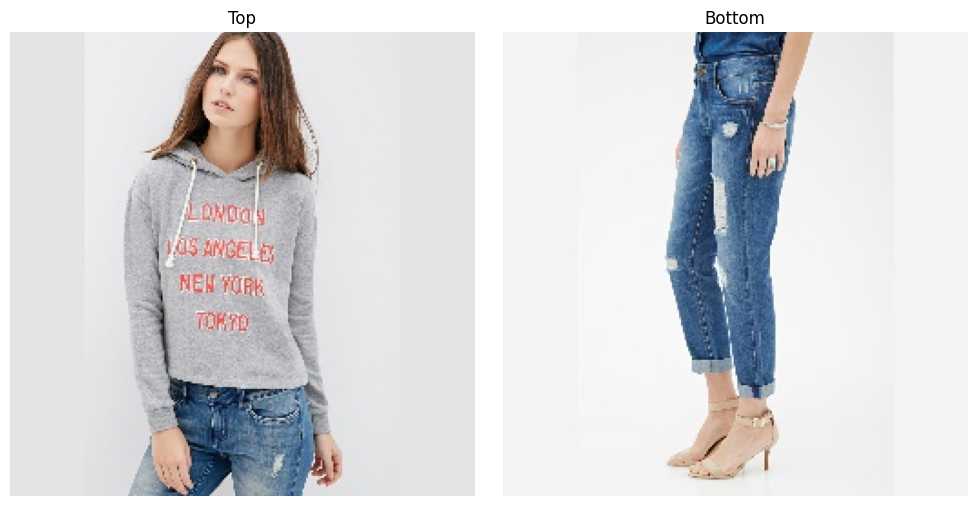

In [ ]:
show_outfit_row(best_outfits.iloc[0])

day 1  |  score = 1.818


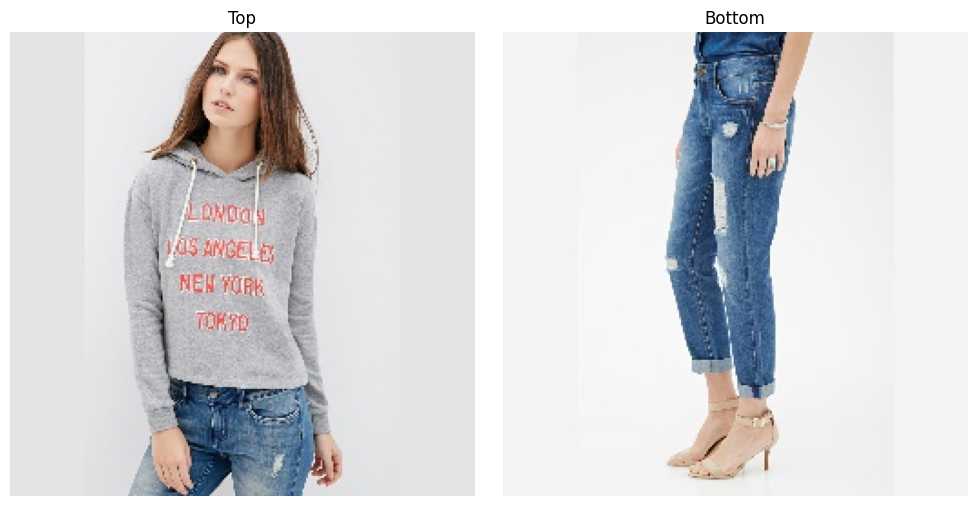

day 2  |  score = 1.816


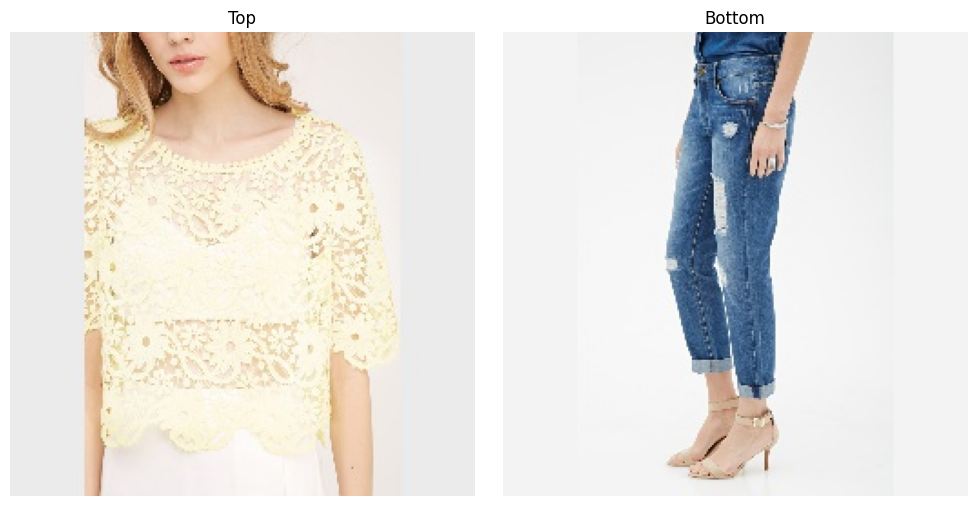

day 3  |  score = 1.813


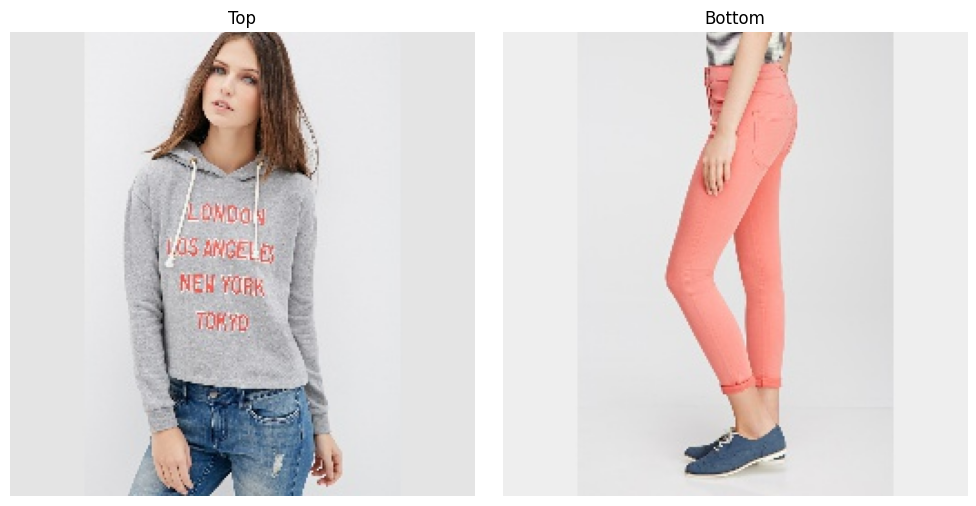

day 4  |  score = 1.810


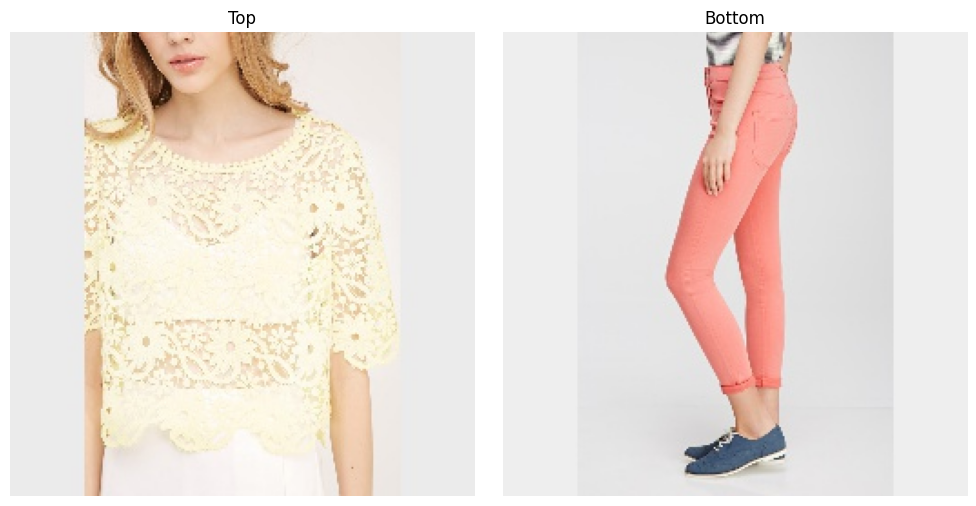

day 5  |  score = 1.717


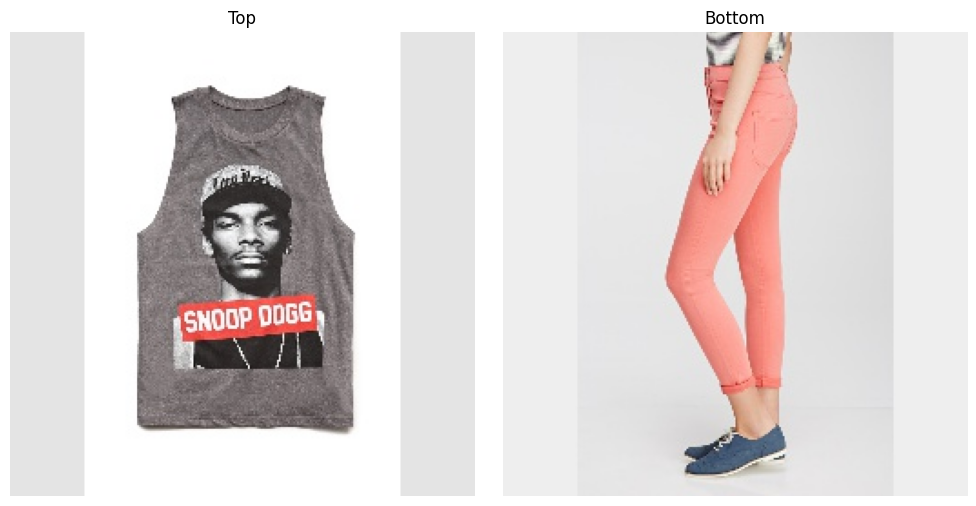

day 6  |  score = 1.705


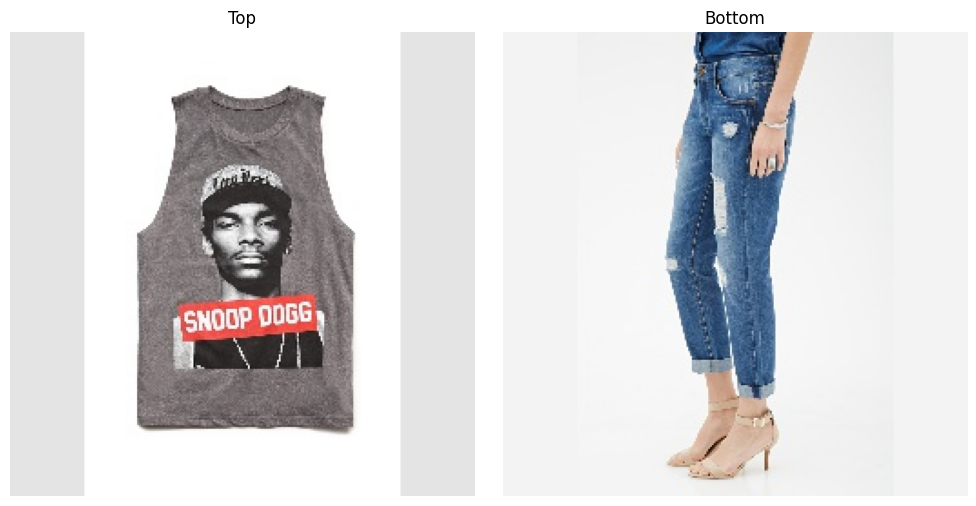

day 7  |  score = 0.000


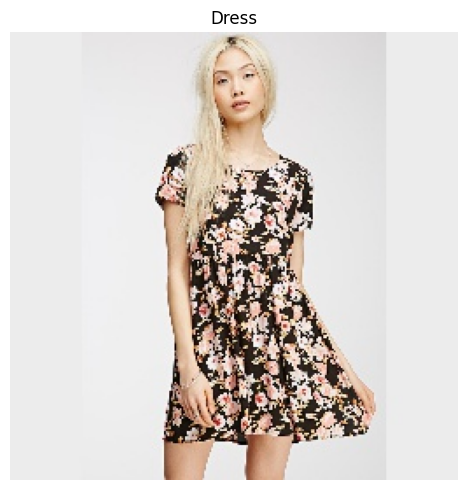

day 8  |  score = 0.000


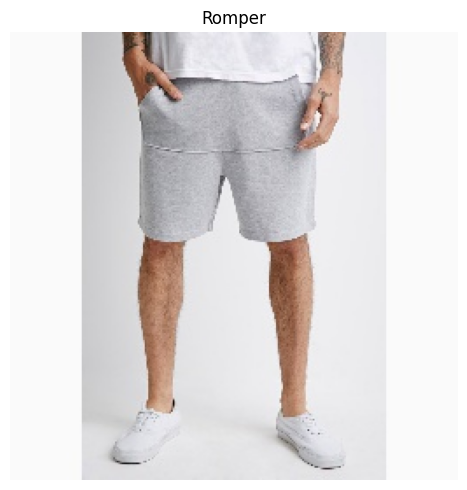

In [ ]:
for _, row in best_outfits.head(30).iterrows():
    print(f"day {row['day']}  |  score = {row['total_score']:.3f}")
    show_outfit_row(row)